In [2]:
!pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 10.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.1/28.1 MB 25.9 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [2]:
!pip install seaborn


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [4]:
pip install rdkit-pypi

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.8/24.8 MB 13.3 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import umap
import seaborn as sns
import os 


from rdkit import DataStructs
from rdkit.Chem.Fingerprints import FingerprintMols
from rdkit import Chem
from rdkit.Chem import Descriptors, AllChem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator
from rdkit.Chem import Draw
from rdkit.Chem import rdMolDescriptors


from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.ensemble import RandomForestRegressor, VotingRegressor
from sklearn.svm import SVR


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### import the smiles_tg.csv file into a dataframe and identify how many unique smiles strings are in the dataset

In [2]:
df = pd.read_csv("smiles_tg.csv")

print(f"Liczba wszystkich wpisów: {len(df)}")
print(f"Liczba unikalnych SMILES: {df['SMILES'].nunique()}")

Liczba wszystkich wpisów: 966
Liczba unikalnych SMILES: 964


### drop the duplicate smiles strings in the dataset, keep the first entry and reset the index

In [3]:
df_unique = df.drop_duplicates(subset='SMILES', keep='first').reset_index(drop=True)
print(f"Liczba po usunięciu duplikatów: {len(df_unique)}")

Liczba po usunięciu duplikatów: 964


### we are going to use the RDKit library to convert the smiles strings into molecular objects that we will use as features for our models
### lets first generate basic descriptors for the molecules
### here you will write a basic function called get_basic_descriptors, that takes a smiles string as input, and returns a dictionary of descriptors the descriptors are the following:

### 'MW': molecular weight
 
### 'HBD': number of hydrogen bond donors

### 'HBA': number of hydrogen bond acceptors

### 'TPSA': topological polar surface area

### 'Rotatable_Bonds': number of rotatable bonds

In [4]:
def get_basic_descriptors(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    descriptors = {
        'MW': Descriptors.MolWt(mol),
        'HBD': rdMolDescriptors.CalcNumHBD(mol),
        'HBA': rdMolDescriptors.CalcNumHBA(mol),
        'TPSA': rdMolDescriptors.CalcTPSA(mol),
        'Rotatable_Bonds': Descriptors.NumRotatableBonds(mol)
    }
    return descriptors

In [5]:
# Przykład
example_smiles = "CCO"

# Oblicz deskryptory
desc = get_basic_descriptors(example_smiles)
print(desc)

{'MW': 46.069, 'HBD': 1, 'HBA': 1, 'TPSA': 20.23, 'Rotatable_Bonds': 0}


next create a function called get_morgan_fingerprint that takes in smiles strings and generates morgan fingerprints

with a radius of 2 and a length nBits= 1024

Return the fingerprint as a list

hint: the Input parameters to the function should be

smiles, radius, nBits

the function should return the fingerprint as a list

this can be done in a very few lines of code (don't complicate it)

In [6]:
# Przykład
smiles = "CCO"  # etanol
mol = Chem.MolFromSmiles(smiles)

print(mol)
print(Descriptors.MolWt(mol))

46.069


next create a function called get_morgan_fingerprint that takes in smiles strings and generates morgan fingerprints

with a radius of 2 and a length nBits= 1024

Return the fingerprint as a list

hint: the Input parameters to the function should be

smiles, radius, nBits

the function should return the fingerprint as a list

this can be done in a very few lines of code (don't complicate it)

In [7]:
def get_morgan_fingerprint(smiles, radius=2, nBits=1024):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        raise ValueError("Nieprawidłowy SMILES")

    fpgen = GetMorganGenerator(radius=radius,fpSize=nBits)
    fp = fpgen.GetFingerprint(mol)
    return list(fp.ToBitString())

In [8]:
# Przykład
smiles = "CC(=O)O"  # etanol
fingerprint = get_morgan_fingerprint(smiles, radius=2, nBits=1024)

print(fingerprint[:10])  # pokaż pierwsze 10 bitów

['0', '0', '0', '0', '0', '0', '0', '0', '0', '0']


In [9]:
print(get_morgan_fingerprint("*c1cccc(-c2nc3ccccc3c(-c3ccc(Oc4ccc(-c5c(-c6ccccc6)c(*)nc6ccccc56)cc4)cc3)c2-c2ccccc2)c1")[:10])

['0', '0', '0', '1', '0', '0', '0', '0', '0', '0']


In [10]:
print(get_morgan_fingerprint("*Oc1ccc(C2(c3ccc(OC(*)=O)cc3)CC3CCC2C3)cc1")[:10])

['0', '0', '0', '0', '0', '0', '0', '0', '0', '0']


In [11]:
print(get_morgan_fingerprint("*c1cccc(C(=O)c2cccc(N3C(=O)c4ccc(C(c5ccc6c(c5)C(=O)N(*)C6=O)(C(F)(F)F)C(F)(F)F)cc4C3=O)c2)c1")[:10])

['0', '0', '0', '0', '0', '0', '0', '0', '0', '1']


Next create a function called get_topological_fingerprint that generates topological fingerprints from SMILES strings. These fingerprints capture the 2D structural features of molecules.

The function should take in a smiles string and nBits=25

return the fingerprint as a list

In [15]:
def get_topological_fingerprint(smiles, nBits=25):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        raise ValueError("Nieprawidłowy SMILES")

    fp = RDKFingerprint(mol,fpSize=nBits)
    return list(fp.ToBitString())

In [13]:
from rdkit.Chem import RDKFingerprint

In [16]:
smiles = "CCO"  # etanol
fingerprint = get_topological_fingerprint(smiles, nBits=25)
print(fingerprint)

['1', '0', '1', '0', '0', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '1', '0', '0', '0', '0', '0', '0', '0', '1']


In [17]:
print(get_topological_fingerprint("*c1cccc(-c2nc3ccccc3c(-c3ccc(Oc4ccc(-c5c(-c6ccccc6)c(*)nc6ccccc56)cc4)cc3)c2-c2ccccc2)c1")[:25])

['1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1']


we are now going to use these functions to generate features for our models.

lets start with the get_basic_descriptors function, use it to convert the smiles strings in the dataset to features

so what you will do here is create a list that contains the descriptors for each smiles string in the dataset

remember, in your function, this should return a dictionary of descriptors, so you will have a single list, where each smile string is represented by a dictionary of descriptors

if you did this correctly and print the output, the first entry should look similar to this:

[{'MW': 167.188, 'HBD': 0, 'HBA': 5, 'TPSA': 75.99, 'Rotatable_Bonds': 0},{.....}]

In [18]:
features_list = [get_basic_descriptors(smiles) for smiles in df_unique['SMILES']]

In [19]:
print(features_list[0])

{'MW': 494.5880000000004, 'HBD': 2, 'HBA': 6, 'TPSA': 95.12, 'Rotatable_Bonds': 14}


In [20]:
print(features_list[3])


{'MW': 174.15599999999998, 'HBD': 2, 'HBA': 4, 'TPSA': 76.66000000000001, 'Rotatable_Bonds': 5}


In [21]:
features_list = []
for smiles in df_unique['SMILES']:
    desc = get_basic_descriptors(smiles)
    if desc is not None:
        features_list.append(desc)

convert this list of dictionaries into a dataframe called df_descriptors

next lets scale the features using the StandardScaler from sklearn.preprocessing

fit and transform the dataframe and we'll call this scaled dataframe X

now that your data is transformed, use KMeans clustering to cluster and fit the scaled dataframe (X).

use n_clusters = 5, and a random_state = 0

extract the labels using kmeans.labels_ and add this as a column a new column in the df_descriptors called 'cluster'

next use the PCA algorithmn to reduce the dimensionality of the dataframe (X) to 2 dimensions

Add the the pca1 and pca2 columns to the df_descriptors dataframe

finally, use the seaborn library to create a scatter plot

set data = descriptors, x = pca1, y = pca2, hue = cluster

In [23]:
df_descriptors = pd.DataFrame(features_list) #zamieniam liste slownikow na dataframe

scaler = StandardScaler()
X = scaler.fit_transform(df_descriptors)

### KMeans

In [24]:
kmeans = KMeans(n_clusters=5, random_state=0)
kmeans.fit(X)

KMeans(n_clusters=5, random_state=0)

In [25]:
df_descriptors['cluster'] = kmeans.labels_

### PCA

In [28]:
pca = PCA(n_components=2)
pca_results = pca.fit_transform(X)

df_descriptors['pca1'] = pca_results[:, 0]
df_descriptors['pca2'] = pca_results[:, 1]

### WYKRES Z SEABORN

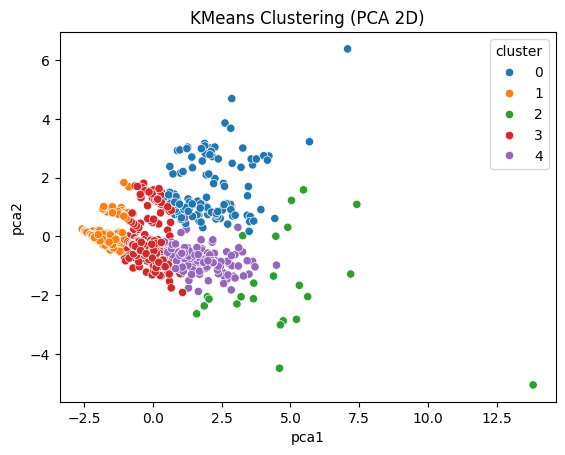

In [32]:
sns.scatterplot(data=df_descriptors, x='pca1', y='pca2', hue='cluster', palette='tab10')
plt.title("KMeans Clustering (PCA 2D)")
plt.show()